In [73]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import category_encoders as ce

%matplotlib inline

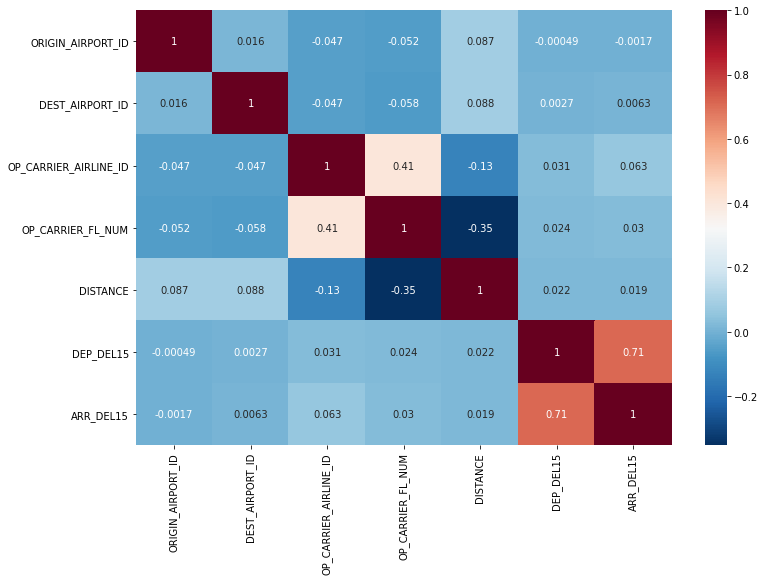

In [74]:
# Daniel's initial correlation matrix

train_df = pd.read_csv('./data/train.csv', index_col = 'ID').sort_index()
train_df.head()
#train_df.describe()

#Some notes on the dataset:
# Local timestampts are useless ? UTC are global, they should be better
# Origin airport id and Origin represent the same
# sort by timestamp when splitting data for no data leakage
# Canceled column might be dropped
# We have 62195 rows with delayed flights and 357292 not delayed flights, highly imbalanced dataset
# Dep_del15 has missing values (like a lot) and distance as well

train_df.drop(columns = ['CANCELLED'], inplace=True)
#train_df.dtypes

plt.figure(figsize = (12,8)) # <-- just sets the figure size 

sns.heatmap(train_df.corr(), 
            annot=True,     # <-- write the numbers on the squares
            cmap='RdBu_r'); # <-- use a "red into blue, reversed" colormap

# Departing delayed is highly correlated with arriving delay, which makes total sense

In [77]:
# Fernandas baseline feature function

def create_columns(_df):
    mod_df = _df.copy()
    
    mod_df.drop(['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'CANCELLED'], inplace = True, axis = 1)
    
    #transform string to datetime
    mod_df['DATE_DEPARTURE_UTC_ts'] = pd.to_datetime(mod_df['DATE_DEPARTURE_UTC'])
    mod_df['DATE_ARRIVAL_UTC_ts'] = pd.to_datetime(mod_df['DATE_ARRIVAL_UTC'])
    mod_df['DATE_DEPARTURE_LCL_ts'] = pd.to_datetime(mod_df['DATE_DEPARTURE_LCL'])
    mod_df['DATE_ARRIVAL_LCL_ts'] = pd.to_datetime(mod_df['DATE_ARRIVAL_LCL'])

    #duration of the flight
    mod_df['Duration_UTC'] = (mod_df['DATE_ARRIVAL_UTC_ts'] - mod_df['DATE_DEPARTURE_UTC_ts']).dt.seconds/60

    #Federal holidays
    mod_df['NewYear_Flag'] = mod_df['DATE_DEPARTURE_UTC'].str.contains('01-01').map({True: 1, False: 0})
    mod_df['MartinLutherKingDay_Flag'] = mod_df['DATE_DEPARTURE_UTC'].str.contains('01-20').map({True: 1, False: 0})
    mod_df['PresidentsDay_Flag'] = mod_df['DATE_DEPARTURE_UTC'].str.contains('02-17').map({True: 1, False: 0})
    mod_df['MemorialDay_Flag'] = mod_df['DATE_DEPARTURE_UTC'].str.contains('05-25').map({True: 1, False: 0})
    mod_df['IndependenceDay_Flag'] = mod_df['DATE_DEPARTURE_UTC'].str.contains('07-04').map({True: 1, False: 0})
    mod_df['ColumbusDay_Flag'] = mod_df['DATE_DEPARTURE_UTC'].str.contains('10-12').map({True: 1, False: 0})
    mod_df['VeteransDay_Flag'] = mod_df['DATE_DEPARTURE_UTC'].str.contains('11-11').map({True: 1, False: 0})
    mod_df['ThanksgivingDay_Flag'] = mod_df['DATE_DEPARTURE_UTC'].str.contains('11-26').map({True: 1, False: 0})
    mod_df['ChristmasDay_Flag'] = mod_df['DATE_DEPARTURE_UTC'].str.contains('12-25').map({True: 1, False: 0})
    
    #NaN values
    mod_df['DEP_DEL15_cat'] = mod_df['DEP_DEL15'].fillna(2).astype('category').map({1: 'delayed', 0: 'not delayed', 2: 'unknown'})
   
    mod_df = mod_df.join(pd.get_dummies(mod_df['DEP_DEL15_cat']))

    return mod_df
    


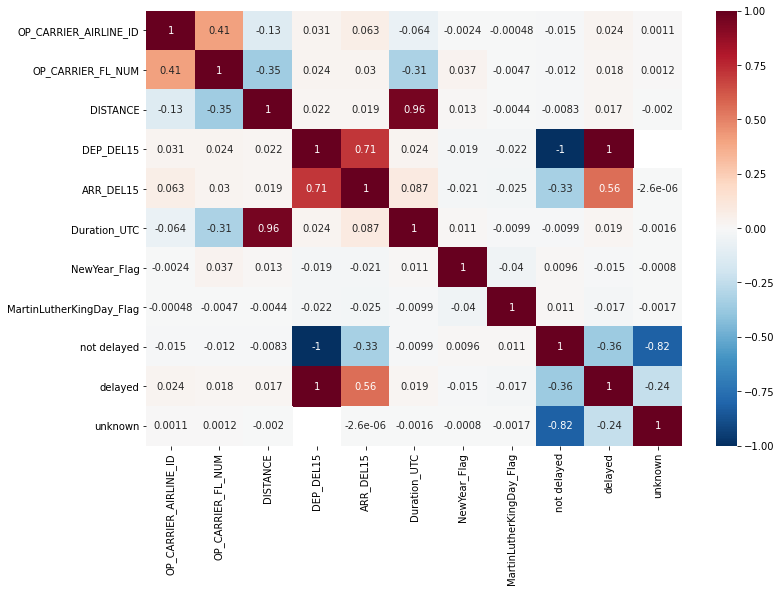

In [80]:
# Baseline correlation matrix

train_df = pd.read_csv('./data/train.csv', index_col = 'ID').sort_index()
train_df = create_columns(train_df)

train_df = train_df.drop(["PresidentsDay_Flag","MemorialDay_Flag","IndependenceDay_Flag","ColumbusDay_Flag","VeteransDay_Flag","ThanksgivingDay_Flag","ChristmasDay_Flag"], axis=1)

plt.figure(figsize = (12,8)) # <-- just sets the figure size 

sns.heatmap(train_df.corr(), 
            annot=True,     # <-- write the numbers on the squares
            cmap='RdBu_r'); # <-- use a "red into blue, reversed" colormap


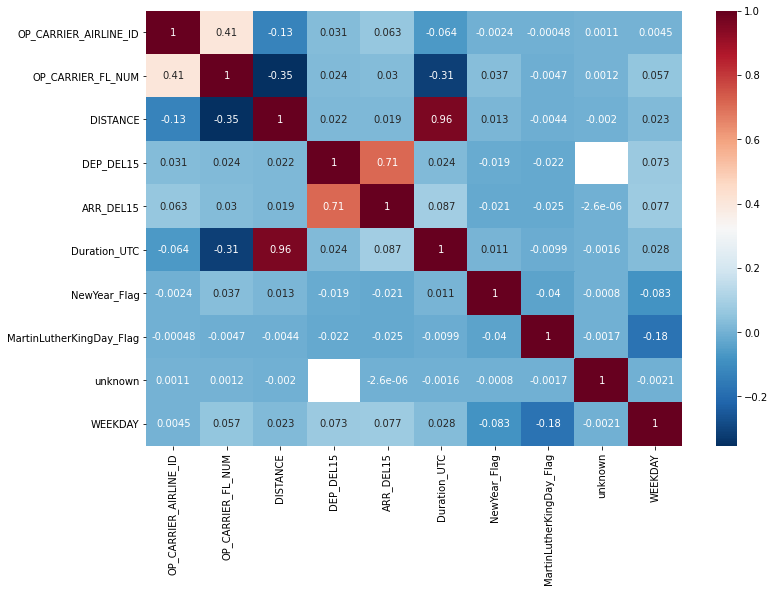

In [85]:
# now with weekdays as well
train_df = pd.read_csv('./data/train.csv', index_col = 'ID').sort_index()
train_df = create_columns(train_df)

def add_weekdays(_df):
    
    df_w_week = _df.copy() 

    df_w_week["WEEKDAY"] = df_w_week.DATE_DEPARTURE_LCL_ts.dt.dayofweek
    
    return df_w_week

train_df = add_weekdays(train_df)


# Baseline + weekdays correlation matrix



train_df = train_df.drop(["delayed", "not delayed", "PresidentsDay_Flag","MemorialDay_Flag","IndependenceDay_Flag","ColumbusDay_Flag","VeteransDay_Flag","ThanksgivingDay_Flag","ChristmasDay_Flag"], axis=1)

plt.figure(figsize = (12,8)) # <-- just sets the figure size 

sns.heatmap(train_df.corr(), 
            annot=True,     # <-- write the numbers on the squares
            cmap='RdBu_r'); # <-- use a "red into blue, reversed" colormap

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f03f25cbf60>]],
      dtype=object)

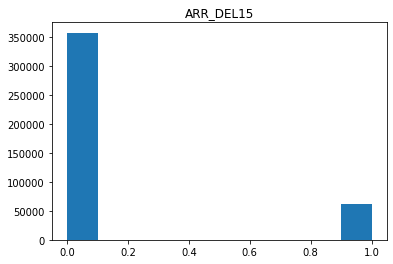

In [90]:
# show target imbalance

train_df.hist(column='ARR_DEL15', grid=False)



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f03f24de4a8>]],
      dtype=object)

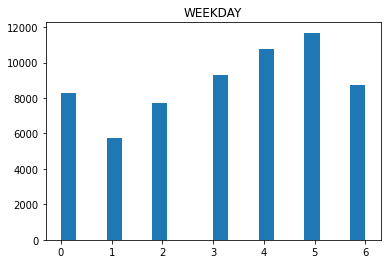

In [103]:
# delayed arrivals over the month

train_df.loc[train_df.ARR_DEL15 == 1].hist(column='WEEKDAY', grid=False, bins=20)

# significant difference from Tuesdays to Saturdays